# Pride and Prejudice and NLP

Looking for some interesting data to apply [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) to I stumbled across [Project Gutenberg](http://www.gutenberg.org/), which offers over 59000 free ebooks. Looking through the list of most downloaded books I found [Pride and Prejudice](http://www.gutenberg.org/ebooks/1342) by Jane Austen - a book I have heard of, but which I have never read. I started wondering whether I can figure out what this book is about by applying NLP to it. In the following analysis I state hypotheses based on my results which are verified at the end of this notebook.

Please keep in mind that this is just a toy project, not a serious text analysis. 

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import seaborn as sns
import networkx as nx

In [2]:
# load Pride and Prejudice as provided by Project Gutenberg  (https://www.gutenberg.org/files/1342/1342-0.txt)
data = open('1342-0.txt', 'r').readlines()[37:13061]

Remove chapter headlines and linebreaks:

In [3]:
data = " ".join(list(data))

data = re.sub('\n|Chapter [0-9]*', '', data)

# Identifying Entities

Apply part-of-speech tagging to identify entities (as singular nouns; NNP)

In [4]:
pos = nltk.pos_tag(nltk.word_tokenize(data))
pos = np.array(pos).transpose()

Identify nouns and remove titles and some characters from the `noun` bag of words.

In [5]:
nouns = pos[0][pos[1] == 'NNP']
nouns = pd.Series(nouns)

for remove in ['Mr.', 'Mrs.', 'Miss', 'Lady', 'Colonel', 'Sir', '”', '“', '*']:
    nouns = nouns.loc[nouns != remove]

Which ones are the most frequent nouns?

In [6]:
nouns.value_counts().iloc[:20]

Elizabeth      629
Darcy          409
Bennet         321
Bingley        302
Jane           286
Wickham        192
Collins        176
Lydia          168
Catherine      126
Gardiner        94
Lizzy           89
Charlotte       85
Longbourn       81
Kitty           71
Netherfield     70
Lucas           68
Meryton         55
London          54
Pemberley       50
William         45
dtype: int64

All of these nouns sound like names. We have found our entities! 

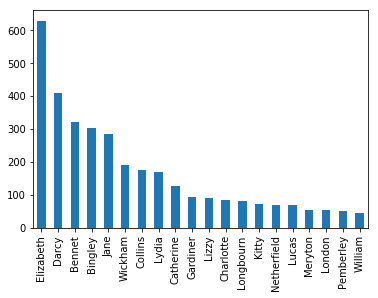

In [7]:
entities = nouns.value_counts().iloc[:20].index
nouns.value_counts().iloc[:20].plot.bar(rot=90)

`Elizabeth` is by far the most common entity - does the name refer to a person?

## People and Places

We extract two-grams in which the first word is an entity and the second word is a verb. In order to make the interpretation of the results easier, we apply lemmatization.

In [8]:
verbs = pd.DataFrame()

lemmatizer = WordNetLemmatizer()

for e in entities:
    for i in np.argwhere([pos[0] == e])[:,1]:
        if 'VB' in pos[1,i+1]:
            df = pd.DataFrame.from_dict({'entity': [pos[0,i]], 'verb': [lemmatizer.lemmatize(pos[0,i+1], wn.VERB)]})
            verbs = pd.concat([verbs, df], ignore_index=True)

We now check which verbs appear most often for the different entities. Since `be` and `have` are by far the most common verbs, and they apply to both people and places, we reject them. Based on the remaining verbs, we decide whether an entity is a person or a place.

First, we perform a cutoff on the number of different verbs that are associated with entities.

In [9]:
for e in entities:
    try:
        print(e, len(verbs.loc[(~verbs.verb.str.contains('be') & 
                               ~verbs.verb.str.contains('have') & 
                               verbs.entity.str.contains(e)),:].groupby('entity').verb.value_counts()))
    except IndexError:
        print(e, 0)

Elizabeth 80
Darcy 46
Bennet 40
Bingley 29
Jane 23
Wickham 9
Collins 25
Lydia 22
Catherine 10
Gardiner 12
Lizzy 3
Charlotte 11
Longbourn 1
Kitty 11
Netherfield 2
Lucas 7
Meryton 2
London 0
Pemberley 0
William 5


People tend to interact with their surrounds, so typically many different verbs are used for them. There is only a small number of entities with only few verbs (<=5 verbs) associated with them. For those cases, we check the actual lists of verbs used.

In [10]:
for e in ['Lizzy', 'Longbourn', 'Netherfield', 'Meryton', 'London', 'Pemberley', 'William']:
    try:
        print(verbs.loc[(~verbs.verb.str.contains('be') & 
                         ~verbs.verb.str.contains('have') & 
                         verbs.entity.str.contains(e)),:].groupby('entity').verb.value_counts())
    except IndexError:
        print(e, 'no verbs associated')

entity  verb   
Lizzy   declare    1
        do         1
        marry      1
Name: verb, dtype: int64
entity     verb
Longbourn  live    1
Name: verb, dtype: int64
entity       verb 
Netherfield  bring    1
             till     1
Name: verb, dtype: int64
entity   verb
Meryton  lose    1
         seem    1
Name: verb, dtype: int64
London no verbs associated
Pemberley no verbs associated
entity   verb     
William  do           2
         accompany    1
         give         1
         remain       1
         stay         1
Name: verb, dtype: int64


There are few pro-active verbs that are indicative of persons and unlikely to describe places: "declare", "marry", "accompany", "do"... We choose to adopt those entities that are associated with these verbs as people - the remaining entities are considered places.

Hence, we split the entities into people and places.

**Hypothesis 1: we split the most common entities into the following lists of people and places**

In [11]:
people = ['Elizabeth', 'Darcy', 'Bennet', 'Bingley', 'Jane', 'Wickham', 'Collins', 'Lydia', 'Catherine',
          'Gardiner', 'Lizzy', 'Charlotte', 'Kitty', 'Lucas', 'William']
places = ['Longbourn', 'Netherfield', 'Meryton', 'London', 'Pemberley']

It turns out that ``Elizabeth`` really refers to a person. This leads to 

**Hypothesis 2: Elizabeth is the main protagonist in the book.**

# Activities

Let's investigate what common verbs are and which people they are associated to.

In [12]:
common_verbs = verbs.verb.value_counts()[:20]
common_verbs

be        301
have      174
do         26
look       25
seem       16
make       15
felt       15
saw        14
say        13
begin      12
take       10
come       10
return      8
listen      8
appear      7
find        7
walk        7
give        7
go          6
try         6
Name: verb, dtype: int64

In [13]:
activities = np.zeros((16, 20))

for i, e in enumerate(people):
    for j, v in enumerate(common_verbs.index.values):
        activities[i, j] = len(verbs.loc[(verbs.entity.str.contains(e) & verbs.verb.str.contains(v)),:])        

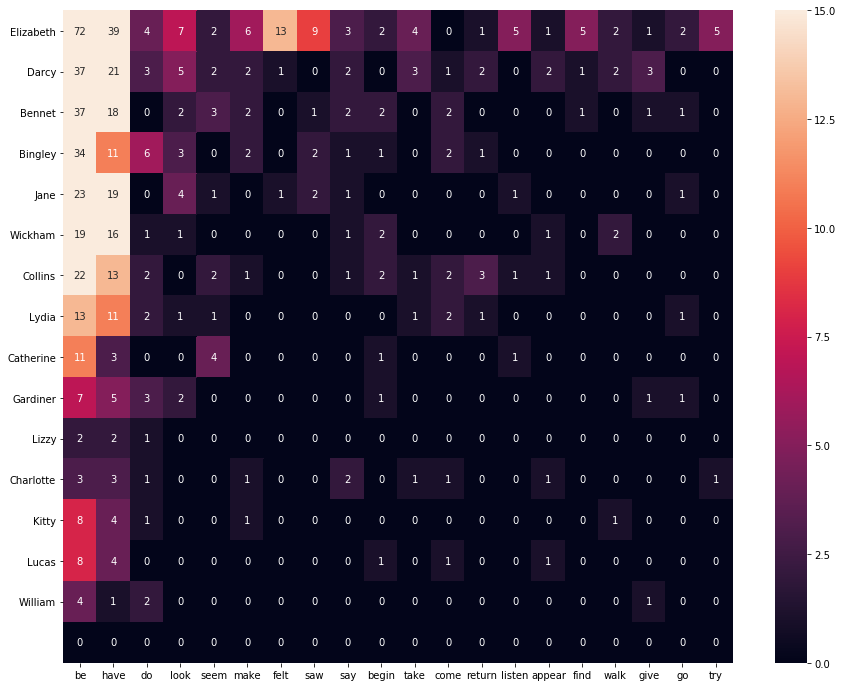

In [14]:
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(activities, annot=True, xticklabels=common_verbs.index.values, yticklabels=people, vmax=15, ax=ax)

`be` and `have` are by far the most common verbs for each of the protagonists. In order to interpret interactions properly, the next word after the verb - typically and adjective or adverb - is important.

The large variety of verbs associated with `Elizabeth` supports the hypothesis that she is the main protagonist in the book. Also, her character is the only character that is strongly associated with activities like feeling, seeing, listening, and finding - activities that are associated with human and emotional interaction.

**Hypothesis 3: a significant fraction of the book is about Elizabeth's emotional state and her interactions with other people.**

Low-number statistics forbids similar conclusions on the other characters.

# Actions

We consider actions that are pointed at other people by investigating three-grams that consist of combinations of entity-verb-adjective.

In [15]:
action = pd.DataFrame()

lemmatizer = WordNetLemmatizer()

for e in people:
    for i in np.argwhere([pos[0] == e])[:,1]:
        if 'VB' in pos[1,i+1] and 'JJ' in pos[1,i+2]:
            df = pd.DataFrame.from_dict({'entity': [pos[0,i]], 'verb': [pos[0,i+1]], 'adj': [pos[0,i+2]]})
            action = pd.concat([action, df], ignore_index=True)

In [16]:
action.adj.unique()

array(['hard', 'comfortable', 'such', 'watchful', 'more', 'much', 'ready',
       'thankful', 'surprised', 'eager', 'little', 'sensible', 'pleased',
       'able', 'impatient', 'considerable', 'tall', 'punctual', 'glad',
       'incapable', 'most', 'likely', 'dead', 'many', 'mindful', 'rid',
       'good-looking', 'sure', 'uncivil', 'indifferent', 'great',
       'evident', 'sixteen', 'anxious', '_your_', 'safe.', 'constant',
       'eloquent', 'urgent', 'first', 'inevitable', 'slight', 'away.',
       'forwarder', 'close', 'odious', 'married'], dtype=object)

We split those adjectives that appear in three-grams into a positive group and a negative group.  

In [17]:
pos_adj = ['comfortable', 'ready', 'thankful', 'eager', 'sensible', 'pleased',
           'able', 'punctual', 'glad', 'likely', 'mindful', 'good-looking', 
           'sure', 'great', 'safe.', 'eloquent', 'married']
neg_adj = ['watchful', 'impatient', 'incapable', 'dead', 'rid',
           'uncivil', 'indifferent', 'anxious', 'inevitable', 'odious']

Now we introduce a "karma" score that adds up the numbers of positive and negative adjectives related to protagonists. While this score is not a direct indicator of a person's benevolence or malevolence, it serves as a general guide to whether protagonists are more commonly associated with positive or negative actions.

In [18]:
score = np.zeros(len(people))

for i in range(len(action)):
    a = action.iloc[i]
    s = 0
    if a.adj in pos_adj:
        s = 1
    elif a.adj in neg_adj:
        s = -1
    score[{p:i for i, p in enumerate(people)}[a.entity]] += s

The following bar chart shows a comparison of the karma score.

Text(0.5, 0, 'karma score')

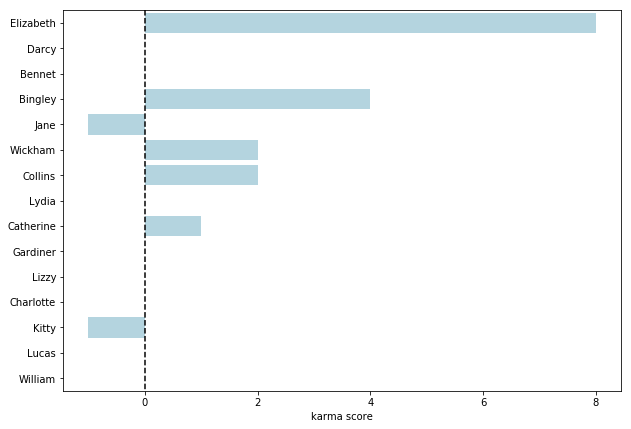

In [19]:
f, ax = plt.subplots(figsize=(10,7))

sns.barplot(x=score, y=people, color='lightblue', ax=ax)
ax.plot([0,0], [-0.5, len(people)], color='black', linestyle='dashed')
ax.set_xlabel('karma score')

``Elizabeth``'s karma score is by far the highest among all protagonists. The second highest is that of ``Bingley``. Accounting for small number statistics by adopting Poisson noise as a measure of uncertainty, the scores of the other protagonists are insignificant and agree with zero within their uncertainties.

**Hypothesis 4: Elizabeth and Bingley are much more associated with positive actions compared to the other protagonists. **

# Interactions

We investigate interactions between the characters. In order to find out who interacts with whom, we search for occurrences in which a name is followed by a verb and then another name follow within the next 5 words. 

In [20]:
interact = pd.DataFrame()

lemmatizer = WordNetLemmatizer()

for e in people:
    for i in np.argwhere([pos[0] == e])[:,1]:
        if 'VB' in pos[1,i+1]:
            for j in range(2, 6):
                if pos[0, i+j] in people:
                    df = pd.DataFrame.from_dict({'entity': [pos[0,i]], 'verb': [pos[0,i+1]],
                                                 'target':[pos[0,i+j]], 'startpos': i, 'endpos':i+j})
                    interact = pd.concat([interact, df], ignore_index=True)

/home/mommermi/software/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


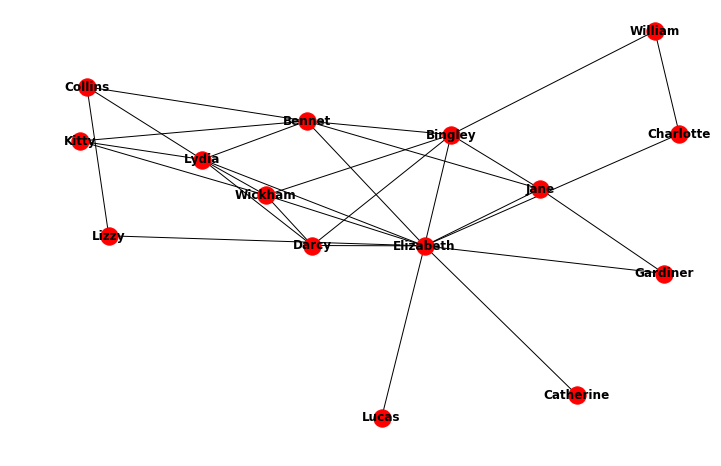

In [21]:
f, ax = plt.subplots(figsize=(12, 8))

G = nx.Graph(ax=ax)
G.add_nodes_from(people)
G.add_edges_from(interact.loc[:, ['entity', 'target']].values)
nx.draw(G, with_labels=True, font_weight='bold')

This graph showcases the interactions between characters, shown as nodes. Edges indicate some form of interaction. The closer characters are to each other, the stronger their interaction, and the more centered a character is in this plot, the more central it is to the plot. 

**Hypothesis 5: The plot is centered around `Elizabeth`, `Jane`, `Bennet`, `Bingley`, and `Darcy`.** 

Which of these interactions are pleasent? We look at the verbs that are used and extract a list of positive verbs:

In [22]:
interact.verb.unique()

array(['felt', 'returned', 'related', 'withdrew', 'gave', 'wondered',
       'looked', 'had', 'smiled', 'received', 'walked', 'was', 'told',
       'admired', 'rejoiced', 'say', 'sent', 'does', 'arrived',
       'entertained', 'appeared', 'has', 'were', 'wants', 'continued',
       'marry', 'followed', 'is', 'accompanied'], dtype=object)

In [23]:
pos_verb = ['smiled', 'admired', 'rejoiced', 'entertained', 'marry', 'accompanied']

Now we can count how often characters interact with each other in a positive manner:

In [24]:
niceness = np.zeros((len(people), len(people)))

for i in range(len(interact)):
    a = interact.iloc[i]
    if a.verb in pos_verb:
        niceness[{p:i for i, p in enumerate(people)}[a.entity],
                 {p:i for i, p in enumerate(people)}[a.target]] += 1

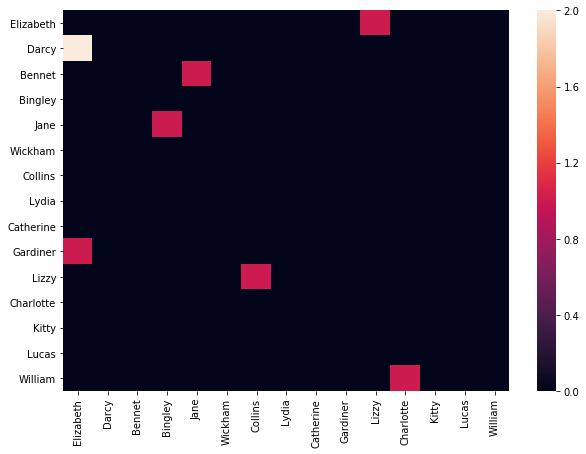

In [25]:
f, ax = plt.subplots(figsize=(10,7))

sns.heatmap(niceness, xticklabels=people, yticklabels=people, ax=ax)

Since the numbers of positive interactions are really small, the significance of this analysis is only poor. Nevertheless, it seems that the most positive interactions occur between Elizabeth and Darcy.

**Hypothesis 6: Although insignificant, interactions between Elizabeth and Darcy seem to be the most positive amongst all characters.**

# Summary

* Hypothesis 1: ['Elizabeth', 'Darcy', 'Bennet', 'Bingley', 'Jane', 'Wickham', 'Collins', 'Lydia', 'Catherine', 'Gardiner', 'Lizzy', 'Charlotte', 'Kitty', 'Lucas', 'William'] are the main characters of the book, whereas ['Longbourn', 'Netherfield', 'Meryton', 'London', 'Pemberley']
 are the main places
* Hypothesis 2: `Elizabeth` is the main protagonist in the book.
* Hypothesis 3: a significant fraction of the book is about `Elizabeth`'s emotional state and her interactions with other people.
* Hypothesis 4: `Elizabeth` and `Bingley` are much more associated with positive actions compared to the other protagonists.
* Hypothesis 5: The plot is centered around `Elizabeth`, `Jane`, `Bennet`, `Bingley`, and `Darcy`.
* Hypothesis 6: Although insignificant, interactions between `Elizabeth` and `Darcy` seem to be the most positive amongst all characters.

# Validation

In order to vaidate these claims, I had to promise my wife to watch the 2005 movie adaptation - one of her favorite movies - with her. Additional information are taken from this [wikipedia article](https://en.wikipedia.org/wiki/Pride_and_Prejudice). Here are the results:

* Hypothesis 1: The separation of entities into characters and places is correct! However, the name `Bennet` refers to an entire family including `Elizabeth`, `Jane`, `Lydia`, and `Kitty`. Interestingly, the analysis did not find Mary Bennet. `Catherine` and `Kitty`, as well as `Elizabeth` and `Lizzy`, refer to the same person, respectively. 
* Hypothesis 2: `Elizabeth` is indeed the main protagonist.
* Hypothesis 3: The novel is a love story and hence indeed focussed on the emotions and interactions of `Elizabeth` with others.
* Hypothesis 4: It is correct that both `Elizabeth` and `Bingley` can be described as "good persons". However, the two are not in a relationship with each other.
* Hypothesis 5: The novel is indeed centered around `Elizabeth` and her relationship with `Darcy`, as well `Jane`'s (her sister) relationship with `Bingley`. `Bennet` is the family name of `Elizabeth` and `Jane`.
* Hypothesis 6: `Elizabeth` and `Darcy` are indeed in a relationship. However, deducing this detail from this analysis would be a long shot.

# Conclusion

Although most hypotheses drawn from this analysis are correct, it would be misleading to think it would be possible to perform an automated synopsis analysis on such a complex work of literature. However, analyses as presented here are certainly able to identify entities and the general genre of the work.